# Recommender System with Collaborative Filtering

First, we need to read the data from the dataset.

In [896]:
import pandas as pd
import numpy as np

In [897]:
# datasets_loc = "datasets"
datasets_loc = "toy_datasets"

In [898]:
ratings = pd.read_csv(datasets_loc + "/ratings.csv", delim_whitespace=True, skiprows=1, names=["UserID", "ProfileID", "Rating"])
# gender = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender"]) (For large dataset)
info = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender", "Name"])

Here is our data. UserID is the user, ProfileID is the profile that user is looking at.

In [899]:
ratings.head()

,UserID,ProfileID,Rating
0,3,1,1
1,3,2,5
2,3,3,1
3,3,4,1
4,3,5,10


In [900]:
info.head()

,UserID,Gender,Name
0,1,F,Anna
1,2,F,Sarah
2,3,M,Bob
3,4,M,Peter
4,5,F,Mary


In [901]:
ratings = pd.merge(info, ratings)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,Anna,2,1
1,1,F,Anna,3,8
2,1,F,Anna,4,10
3,1,F,Anna,6,2
4,1,F,Anna,8,1
...,...,...,...,...,...
63,10,F,Helen,8,1
64,11,F,Emma,3,6
65,11,F,Emma,8,1
66,11,F,Emma,9,10


We map the rating to like/ dislike. Rating smaller than 5 will consider as a dislike to the profile.

In [902]:
ratings["Rating"] = np.where(ratings["Rating"] < 5, -1, 1)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,Anna,2,-1
1,1,F,Anna,3,1
2,1,F,Anna,4,1
3,1,F,Anna,6,-1
4,1,F,Anna,8,-1
...,...,...,...,...,...
63,10,F,Helen,8,-1
64,11,F,Emma,3,1
65,11,F,Emma,8,-1
66,11,F,Emma,9,1


Due to large data set, we need to reduce the data records.

In [903]:
ratings = ratings[(ratings["UserID"] <= 1000) & (ratings["ProfileID"] <= 1000)]
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,Anna,2,-1
1,1,F,Anna,3,1
2,1,F,Anna,4,1
3,1,F,Anna,6,-1
4,1,F,Anna,8,-1
...,...,...,...,...,...
63,10,F,Helen,8,-1
64,11,F,Emma,3,1
65,11,F,Emma,8,-1
66,11,F,Emma,9,1


# Preparing data for Collaborative Filtering  

Data here only contains the user likes. Dislike rating and no rating will be considered as NaN.

In [904]:
user_ratings = ratings.pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
user_ratings.head()

Rating                                                  
ProfileID     1    2    3    4    5    6    7    8    9    10   11
UserID                                                            
1            NaN -1.0  1.0  1.0  NaN -1.0 -1.0 -1.0  NaN  NaN  NaN
2            NaN  NaN -1.0  1.0  NaN -1.0 -1.0 -1.0  1.0  NaN -1.0
3           -1.0  1.0 -1.0 -1.0  1.0 -1.0  NaN  1.0 -1.0  NaN  NaN
4            1.0 -1.0  NaN  NaN  1.0 -1.0  NaN  NaN  NaN  NaN  NaN
5            NaN -1.0  NaN  1.0  NaN -1.0  1.0 -1.0  1.0 -1.0  NaN

So here, we fill all NaN to 0. 

In [905]:
user_ratings = user_ratings.fillna(0)
user_ratings

Rating                                                  
ProfileID     1    2    3    4    5    6    7    8    9    10   11
UserID                                                            
1            0.0 -1.0  1.0  1.0  0.0 -1.0 -1.0 -1.0  0.0  0.0  0.0
2            0.0  0.0 -1.0  1.0  0.0 -1.0 -1.0 -1.0  1.0  0.0 -1.0
3           -1.0  1.0 -1.0 -1.0  1.0 -1.0  0.0  1.0 -1.0  0.0  0.0
4            1.0 -1.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0  0.0  0.0
5            0.0 -1.0  0.0  1.0  0.0 -1.0  1.0 -1.0  1.0 -1.0  0.0
6            1.0  1.0 -1.0  0.0 -1.0  0.0 -1.0  1.0  0.0  1.0  0.0
7            1.0  1.0  0.0  0.0  1.0 -1.0  0.0 -1.0 -1.0  1.0  1.0
8            0.0  0.0  1.0  1.0  0.0  0.0 -1.0  0.0 -1.0 -1.0 -1.0
9           -1.0  1.0  0.0 -1.0  0.0 -1.0  0.0  1.0  0.0  0.0  1.0
10           0.0 -1.0  1.0 -1.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0
11           0.0  0.0  1.0  0.0  0.0  0.0  0.0 -1.0  1.0 -1.0  0.0

In [906]:
# Clear pivot table structure to extra index and columns

user_ratings_df = user_ratings.copy()

user_ratings_df.columns = user_ratings.columns.droplevel(0)
user_ratings_df.name = None
user_ratings_df = user_ratings_df.reset_index()
user_ratings_df.index = user_ratings_df["UserID"]
user_ratings_df.index.name = "UserID"
user_ratings_df.drop("UserID", axis="columns", inplace=True)

user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,-1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0
2,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0
3,-1.0,1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0
4,1.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-1.0,0.0,1.0,0.0,-1.0,1.0,-1.0,1.0,-1.0,0.0
6,1.0,1.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,-1.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0
9,-1.0,1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,0.0,1.0


# Item-based Collaborative Filtering
With KNN algorithm, we can find the similar profiles to the profile that user is looking at. 

In [907]:
from sklearn.model_selection import train_test_split

train_user_ratings_df, test_user_ratings_df = train_test_split(user_ratings_df, test_size=0.2)

In [908]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(train_user_ratings_df.T)

# Here, skipped the cosine similarity matrix

# Same dataset (traning and testing), so nearest is itself (For now)
distances, indices = knn.kneighbors(train_user_ratings_df.T.values, n_neighbors=3)

In [909]:
# Predict like/ dislike for a Profile by a User

def findNearestProfiles(profile_id):
    # Get the index for a profile
    index_of_profile = test_user_ratings_df.T.index.tolist().index(profile_id)

    # Find the indices for similar profiles
    sim_profiles = indices[index_of_profile].tolist()

    # Find the distances between the profile and similar profiles
    sim_profiles_distances = distances[index_of_profile].tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if index_of_profile in sim_profiles:
        # The position of the profile in the list of similar profiles
        index_of_profile_in_sim = sim_profiles.index(index_of_profile)

        # Remove the profile from the list of similar profiles
        sim_profiles.pop(index_of_profile_in_sim)

        # Remove the profile from the list of similar profiles distances
        sim_profiles_distances.pop(index_of_profile_in_sim)

    # print("The nearest profiles to Profile {} are:".format(profile_id), ["Profile {}".format(train_user_ratings_df.columns[i]) for i in sim_profiles])
    # print("The distance from Profile {}:".format(profile_id), sim_profiles_distances)
    # print("Returned", sim_profiles, sim_profiles_distances)
    return sim_profiles, sim_profiles_distances

# findNearestProfiles(1)

In [910]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = test_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = test_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the profile
    profile_ratings = test_user_ratings_df.T.iloc[index_of_profile].values.tolist()

    # Find the nearest neighbors of the profile
    sim_profiles, sim_profiles_distances = findNearestProfiles(profile_id)
    
    # Get the ratings for the similar profiles
    sim_profiles_ratings = [test_user_ratings_df.T.iloc[i].values.tolist() for i in sim_profiles]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_profiles_distances[i] * (sim_profiles_ratings[i][index_of_user] - average(test_user_ratings_df.T.iloc[sim_profiles[i]].values.tolist())) for i in range(len(sim_profiles))])
    denominator = sum(sim_profiles_distances)

    if denominator > 0:
        predicted_rating = average(profile_ratings) + numerator / denominator 
    else:
        predicted_rating = average(profile_ratings)

    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(5, 4)

In [911]:
def recommender_system_item_based_CF(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if test_user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [912]:
# Generating entire item-based prediction matrix
predicted_ratings = test_user_ratings_df.T.copy()

for user_id in test_user_ratings_df.index:
    recommender_system_item_based_CF(user_id)
pd.DataFrame(predicted_ratings)

UserID,8,4,7
ProfileID,,,
1,1.333333,0.333333,0.333333
2,-0.730394,0.067401,0.662993
3,-0.509468,0.490532,1.018936
4,-0.192310,0.807690,0.384619
5,0.791873,0.604064,0.604064
6,-1.535118,-0.535118,0.070235
7,-0.358066,-0.320967,-0.320967
8,-1.076481,-0.590185,0.666667
9,-0.863034,-0.568483,-0.568483


In [913]:
test_user_ratings_df.T

UserID,8,4,7
ProfileID,,,
1,0.0,1.0,1.0
2,0.0,-1.0,1.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,0.0,1.0,1.0
6,0.0,-1.0,-1.0
7,-1.0,0.0,0.0
8,0.0,0.0,-1.0
9,-1.0,0.0,-1.0


In [914]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_user_ratings_df.T.values, predicted_ratings.values))
rmse

0.8559867895380426

In [915]:
# Recommender system for a random user

import random

predicted_ratings = test_user_ratings_df.T.copy()

user_id = random.choice(test_user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_item_based_CF(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = test_user_ratings_df.loc[user_id, test_user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Jack:
('Bob', 1.0189359115567174)
('Peter', 0.38461921323008647)


# User-based Collaborative Filtering with Jaccard Similarity

In [942]:
# Keep the ratings in binary values only
user_ratings_df = user_ratings_df.replace(-1, 0)

In [943]:
user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [944]:
import scipy.spatial

jaccard = scipy.spatial.distance.cdist(user_ratings_df, user_ratings_df, metric="jaccard")
sim_users_distance_df = pd.DataFrame(jaccard, index=user_ratings_df.index.values, columns=user_ratings_df.index.values)
sim_users_distance_df

,1,2,3,4,5,6,7,8,9,10,11
1,0.000000,0.666667,1.000000,1.00,0.750000,1.0,1.000000,0.000000,1.000000,0.666667,0.666667
2,0.666667,0.000000,1.000000,1.00,0.333333,1.0,1.000000,0.666667,1.000000,1.000000,0.666667
3,1.000000,1.000000,0.000000,0.75,1.000000,0.6,0.666667,1.000000,0.500000,1.000000,1.000000
4,1.000000,1.000000,0.750000,0.00,1.000000,0.8,0.600000,1.000000,1.000000,1.000000,1.000000
5,0.750000,0.333333,1.000000,1.00,0.000000,1.0,1.000000,0.750000,1.000000,0.750000,0.750000
6,1.000000,1.000000,0.600000,0.80,1.000000,0.0,0.500000,1.000000,0.600000,1.000000,1.000000
7,1.000000,1.000000,0.666667,0.60,1.000000,0.5,0.000000,1.000000,0.666667,1.000000,1.000000
8,0.000000,0.666667,1.000000,1.00,0.750000,1.0,1.000000,0.000000,1.000000,0.666667,0.666667
9,1.000000,1.000000,0.500000,1.00,1.000000,0.6,0.666667,1.000000,0.000000,1.000000,1.000000
10,0.666667,1.000000,1.000000,1.00,0.750000,1.0,1.000000,0.666667,1.000000,0.000000,0.666667


In [945]:
# Find nearest users with Jaccard distance

def findNearestUsersWithJaccard(user_id):
    # Extract the sorted distance of its neighbours for a user
    sim_users_distances_series = sim_users_distance_df[user_id].nsmallest(3)
    sim_users = [i for i in sim_users_distances_series.index]
    sim_users_distances = sim_users_distances_series.values.tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if user_id in sim_users:
        # The index of the user in the list of similar users
        index_of_user_in_sim = sim_users.index(user_id)

        # Remove the user from the list of similar users
        sim_users.pop(index_of_user_in_sim)

        # Remove the user from the list of similar users distances
        sim_users_distances.pop(index_of_user_in_sim)

    # print("The nearest users to User {} are:".format(user_id), ["User {}".format(i) for i in sim_users])
    # print("The distance from User {}:".format(user_id), sim_users_distances)
    return sim_users, sim_users_distances

# findNearestUsersWithJaccard(4)

In [946]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the user
    user_ratings = user_ratings_df.iloc[index_of_user].values.tolist()

    # Find the nearest neighbors of the user
    sim_users, sim_users_distances = findNearestUsersWithJaccard(user_id)
    
    # Get the ratings for the similar users
    sim_users_ratings = [user_ratings_df.loc[i].values.tolist() for i in sim_users]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_users_distances[i] * (sim_users_ratings[i][index_of_profile] - average(user_ratings_df.loc[sim_users[i]].values.tolist())) for i in range(len(sim_users))])
    denominator = sum(sim_users_distances)

    predicted_rating = average(user_ratings) + numerator / denominator 

    # print("Returned", sim_users, sim_users_distances)
    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(3, 11)

In [947]:
def recommender_system_user_based_CF_Jaccard(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [948]:
# Generating the entire user-based jaccard prediction matrix
predicted_ratings = user_ratings_df.T.copy()

for user_id in user_ratings_df.index:
    recommender_system_user_based_CF_Jaccard(user_id)
pd.DataFrame(predicted_ratings)

UserID,1,2,3,4,5,6,7,8,9,10,11
ProfileID,,,,,,,,,,,
1,0.0,-0.030303,0.495868,0.272727,0.090909,0.462810,1.190083,0.0,0.495868,0.0,0.0
2,0.0,-0.030303,0.950413,0.828283,0.090909,1.008264,0.644628,0.0,0.950413,0.0,0.0
3,0.0,0.636364,-0.049587,-0.171717,0.783217,0.008264,0.190083,0.0,-0.049587,1.0,0.5
4,1.0,0.969697,-0.049587,-0.171717,1.090909,0.008264,0.190083,1.0,-0.049587,1.0,1.0
5,0.0,-0.030303,-0.049587,0.828283,0.090909,1.008264,0.735537,0.0,0.404959,0.0,0.0
6,0.0,-0.030303,-0.049587,-0.171717,0.090909,0.008264,0.190083,0.0,-0.049587,0.0,0.0
7,0.0,0.303030,-0.049587,-0.171717,0.090909,0.008264,0.190083,0.0,-0.049587,0.0,0.0
8,0.0,-0.030303,0.950413,0.383838,0.090909,0.553719,0.644628,0.0,0.950413,0.0,0.0
9,1.0,0.303030,-0.049587,-0.171717,0.398601,0.008264,0.190083,1.0,-0.049587,0.0,0.5


In [949]:
user_ratings_df.T

UserID,1,2,3,4,5,6,7,8,9,10,11
ProfileID,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [950]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(user_ratings_df.T.values, predicted_ratings.values))
rmse

0.39847958980646864

In [957]:
# Recommender system for a user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_user_based_CF_Jaccard(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Peter:
('Sarah', 0.8282828282828281)
('Amy', 0.3838383838383838)
('Helen', 0.2727272727272727)
('Emma', 0.2727272727272727)


# Visualize the network graph

Using the non pivot version (ratings) to visualize.

In [486]:
# Keep only "like" edges
ratings = ratings[ratings["Rating"] == 1]

## For small dataset visualization

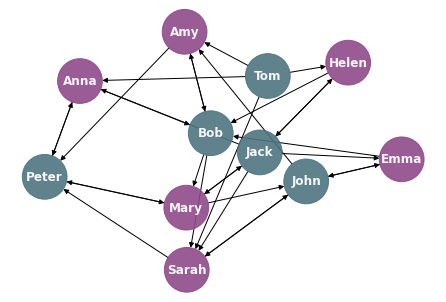

In [492]:
# Remarks: This won't plot node without positive rating associated with it.
# As negative rating has been remove before

import matplotlib.pyplot as plt
import networkx as nx

gr = nx.from_pandas_edgelist(ratings, "UserID", "ProfileID", "Rating", create_using=nx.DiGraph())

mapping = dict(info[["UserID", "Name"]].values.tolist())
color_map = []
for node in gr.nodes():
    if info.loc[info["UserID"] == node, "Gender"].values[0] == "M":
        color_map.append([0.3, 0.46, 0.5, 0.9])
    else:
        color_map.append([0.56, 0.29, 0.54, 0.9])

gr = nx.relabel_nodes(gr, mapping)
pos = nx.fruchterman_reingold_layout(gr)
nx.draw(gr, pos, with_labels=True, node_size=2000, node_color=color_map, font_color="whitesmoke", font_weight="semibold")
plt.show()

## For large dataset visualization

In [99]:
# Only execute this with large dataset

import graph_tool.all as gt 
import random
from IPython.display import Image

network_graph_file = "network-graph-" + str(random.randint(0, 2e9)) + ".png"

g = gt.Graph(directed=True)
vmap = g.add_edge_list(ratings[["UserID", "ProfileID"]].to_numpy(), hashed=True)
pos = gt.fruchterman_reingold_layout(g, n_iter=10)

v_size = g.new_vertex_property("double")
g.vertex_properties["v_size"] = v_size

v_font_size = g.new_vertex_property("double")
g.vertex_properties["v_font_size"] = v_font_size

v_pen_width = g.new_vertex_property("double")
g.vertex_properties["v_pen_width"] = v_pen_width
 
for v in g.vertices():
    v_size[v] = (1 + v.in_degree() * 4) * (1000 / g.num_vertices())
    v_font_size[v] = (1 + v.in_degree()) * (400 / g.num_vertices())
    v_pen_width[v] = (1 + v.in_degree()) * (100 / g.num_vertices())

gt.graph_draw(g, vertex_text=vmap, pos=pos, vertex_size=v_size, vertex_font_size=v_font_size, vertex_fill_color=[0.2, 0.4, 0.53, 0.9], vertex_pen_width=v_pen_width, vertex_font_family="roboto", output_size=(2048, 2048), bg_color=[1, 1, 1, 1], output=network_graph_file)

Image(url=network_graph_file)

# Below are the cells that I haven't finished yet.

In [ ]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
# def standardize(row):
#     new_row = (row - row.mean()) / (row.max() - row.min())
#     return new_row

# user_ratings_std = user_ratings.apply(standardize)
# user_ratings_std

In [32]:
# Profile-Profile Similarity with Cosine similarity

def calculate_similarity(data):
    similarity = cosine_similarity(data)
    return similarity

profile_similarity = calculate_similarity(user_ratings.T)
profile_similarity_df = pd.DataFrame(profile_similarity, index=user_ratings_df.columns.values, columns=user_ratings_df.columns.values)
profile_similarity_df

,1,2,5
1,1.000000,0.000000,0.707107
2,0.000000,1.000000,0.707107
5,0.707107,0.707107,1.000000


In [34]:
# Making recommendations

def get_similar_profile(profile_id, user_rating):
    similar_score = profile_similarity_df[profile_id] * user_rating
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

result = get_similar_profile(1, 1)
result


1    1.000000
5    0.707107
2    0.000000
Name: 1, dtype: float64